In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sc
import math

plots_dir = 'S:\\lab_winter\\martin\\MED14_PRO-seq_final\\plots\\TT-seq\\' # directory for output plots

In [3]:
####################################
#### load in all the gene lists ####
####################################

# DEseq2 dataframe
DEseq_TT_1h_df = pd.read_csv('S:\\lab_winter\\martin\\MJ-19-1\\20190418_JaegerWinter2019TTseqKBM7\\DifferentialExpression\\differential.expression.estimates_1h.txt', sep="\t")
DEseq_TT_2h_df = pd.read_csv('T:\\groups\\lab_winter\\martin\\MJ-19-1_Cramer_lab\\differential.expression.estimates_2nddTAG72h.txt', sep="\t")
DEseq_TT_NVP2_df = pd.read_csv('T:\\groups\\lab_winter\\martin\\MJ-19-1_Cramer_lab\\differential.expression.estimates_2ndNVP230.txt', sep="\t")
DEseq_TT_combo_df = pd.read_csv('T:\\groups\\lab_winter\\martin\\MJ-19-1_Cramer_lab\\differential.expression.estimates_2nddTAG72hNVP230.txt', sep="\t")

SE_genes = pd.read_excel('S:\\lab_winter\\martin\\MED14_PRO-seq_final\\other_final_files\\SE_and_control_gene_sets\\SE_464_genes.xlsx')
#SE_ctrl_genes = pd.read_excel('S:\\lab_winter\\martin\\Mediator_CRC\\SE_control_423_all.xlsx')

TF_genes = pd.read_excel('S:\\lab_winter\\martin\\MED14_PRO-seq_final\\other_final_files\\SE_and_control_gene_sets\\TF_53_genes.xlsx')
#TF_ctrl_TFs = pd.read_excel('S:\\lab_winter\\martin\\Mediator_CRC\\TF_control_51_onlyTFs.xlsx')
#TF_ctrl_genes = pd.read_excel('S:\\lab_winter\\martin\\Mediator_CRC\\TF_control_51_all.xlsx')

autoreg_genes = pd.read_excel('S:\\lab_winter\\martin\\MED14_PRO-seq_final\\other_final_files\\SE_and_control_gene_sets\\autoregulatory_6motifs_24_genes.xlsx')
#CRC_ctrl_TFs = pd.read_excel('S:\\lab_winter\\martin\\Mediator_CRC\\CRC_control_22_onlyTFs.xlsx')
#CRC_ctrl_genes = pd.read_excel('S:\\lab_winter\\martin\\Mediator_CRC\\CRC_control_22_all.xlsx')

In [12]:
##########################################
#### get genes for GO-term enrichment ####
##########################################

### first 2h dTAG7
all_dTAG7_IDs = DEseq_TT_2h_df.gene_id.dropna().tolist()

clean_dTAG7 = []
for x in all_dTAG7_IDs:
    entry = x.replace('NA','').strip()
    if len(entry.split(" ")) > 1:
        for i in range(len(entry.split(" "))):
            clean_dTAG7.append(entry.split(" ")[i])
    else:
        clean_dTAG7.append(entry)
clean_dTAG7 = set(clean_dTAG7)
clean_dTAG7 = pd.DataFrame(list(clean_dTAG7), columns=['geneID'])

#clean_dTAG7.to_excel("S:\\lab_winter\\martin\\MED14_PRO-seq_final\\other_final_files\\MJ-19-30_dTAG7_NVP2_combo\\TT-seq_DE_2h_all_ENSEMBL_IDs.xlsx")

In [36]:
##### make .rnk file for Broad Genepattern tool "GSEA_preranked" => col1=gene_ID | col2=log2FC

###### first for 2h dTAG7

# this is a dictionary of ENSEMBL IDs which have a unique HGNC symbol (but one HGNC symbol can have multiple ENSEMBL IDs!)
ENSEMBL_to_HGNC = pd.read_csv("T:\\groups\\lab_winter\\reference_files\\geneID_dictionaries\\ENSEMBL-Gene-Stable-ID_to_HGNC-Symbol.txt", sep="\t")
ENSEMBL_to_HGNC.columns = ['ENSG', 'HGNC']
ENSEMBL_to_HGNC = ENSEMBL_to_HGNC.drop_duplicates('ENSG').set_index('ENSG', verify_integrity=True) # we lose 7 IDs because they occur more than once

# get log2FC for each geneID
rank_2h_df = DEseq_TT_2h_df[['gene_id','log2FoldChange']].dropna()

def strip(str):
    clean = str.replace('NA', '').strip()
    return clean

rank_2h_df['clean_ID'] = rank_2h_df.gene_id.apply(strip)
rank_2h_df = rank_2h_df.loc[:,['clean_ID', 'log2FoldChange']]

# here we explode rows with multiple geneIDs into separate rows => now exactly 1 ID per row, but several IDs occur more than once
rank_2h_df = rank_2h_df.set_index(rank_2h_df.columns.drop('clean_ID',1).tolist()).clean_ID.str.split(' ', expand=True).stack().reset_index().rename(columns={0:'clean_ID'}).loc[:, rank_2h_df.columns]
# remove lines without ENSG ID
rank_2h_df = rank_2h_df[rank_2h_df.clean_ID.str.contains('ENSG')]
# get the HGNC gene name for each ENSEMBL ID
rank_2h_df = rank_2h_df.join(ENSEMBL_to_HGNC, on='clean_ID')
# remove entries without HGNC name
rank_2h_df = rank_2h_df[~rank_2h_df.HGNC.isnull()]

######### here it starts getting arbitrary => first I remove ENSEMBL IDs which don't have an HGNC Symbol; then I'm resolving duplicated geneIDs by retaining those with lowest log2FC; then I arbitrarily keep the first occuring geneID for IDs with the exact same log2FC
# boil down HGNC IDs, retaining the one with minimal log2FC for those which occur more than once
rank_2h_df = rank_2h_df.groupby('HGNC').min()
# kick out HGNCs which have the exact same log2FC; retaining the first occuring HGNC in this case
rank_2h_df = pd.DataFrame(rank_2h_df.log2FoldChange.drop_duplicates())

#rank_2h_df.to_csv("S:\\lab_winter\\martin\\MED14_PRO-seq_final\\other_final_files\\MJ-19-30_dTAG7_NVP2_combo\\MJ-19-30_TT-seq_2h_all_16982_log2FC_ranked_for_GSEA.rnk", sep="\t", header=False) #### this file is used as input for Broad's GenePattern tool (GSEApreranked module with standard settings)

In [37]:
###### then for combo dTAG7+NVP2

# this is a dictionary of ENSEMBL IDs which have a unique HGNC symbol (but one HGNC symbol can have multiple ENSEMBL IDs!)
ENSEMBL_to_HGNC = pd.read_csv("T:\\groups\\lab_winter\\reference_files\\geneID_dictionaries\\ENSEMBL-Gene-Stable-ID_to_HGNC-Symbol.txt", sep="\t")
ENSEMBL_to_HGNC.columns = ['ENSG', 'HGNC']
ENSEMBL_to_HGNC = ENSEMBL_to_HGNC.drop_duplicates('ENSG').set_index('ENSG', verify_integrity=True) # we lose 7 IDs because they occur more than once

# get log2FC for each geneID
rank_combo_df = DEseq_TT_combo_df[['gene_id','log2FoldChange']].dropna()

def strip(str):
    clean = str.replace('NA', '').strip()
    return clean

rank_combo_df['clean_ID'] = rank_combo_df.gene_id.apply(strip)
rank_combo_df = rank_combo_df.loc[:,['clean_ID', 'log2FoldChange']]

# here we explode rows with multiple geneIDs into separate rows => now exactly 1 ID per row, but several IDs occur more than once
rank_combo_df = rank_combo_df.set_index(rank_combo_df.columns.drop('clean_ID',1).tolist()).clean_ID.str.split(' ', expand=True).stack().reset_index().rename(columns={0:'clean_ID'}).loc[:, rank_combo_df.columns]
# remove lines without ENSG ID
rank_combo_df = rank_combo_df[rank_combo_df.clean_ID.str.contains('ENSG')]
# get the HGNC gene name for each ENSEMBL ID
rank_combo_df = rank_combo_df.join(ENSEMBL_to_HGNC, on='clean_ID')
# remove entries without HGNC name
rank_combo_df = rank_combo_df[~rank_combo_df.HGNC.isnull()]

######### here it starts getting arbitrary => first I remove ENSEMBL IDs which don't have an HGNC Symbol; then I'm resolving duplicated geneIDs by retaining those with lowest log2FC; then I arbitrarily keep the first occuring geneID for IDs with the exact same log2FC
# boil down HGNC IDs, retaining the one with minimal log2FC for those which occur more than once
rank_combo_df = rank_combo_df.groupby('HGNC').min()
# kick out HGNCs which have the exact same log2FC; retaining the first occuring HGNC in this case
rank_combo_df = pd.DataFrame(rank_combo_df.log2FoldChange.drop_duplicates())

#rank_combo_df.to_csv("S:\\lab_winter\\martin\\MED14_PRO-seq_final\\other_final_files\\MJ-19-30_dTAG7_NVP2_combo\\MJ-19-30_TT-seq_combo_all_17009_log2FC_ranked_for_GSEA.rnk", sep="\t", header=False) #### this file is used as input for Broad's GenePattern tool (GSEApreranked module with standard settings)

# gene lists to compare were:
# S:\\lab_winter\\martin\\MED14_PRO-seq_final\\other_final_files\\SE_and_control_gene_sets\\
# autoregulatory_6motifs_24_genes_HGNC_only.txt
# TF_53_genes_HGNC_only.txt
# SE_464_genes_HGNC_only.txt

In [41]:
#### get the intersection of genes, which have log2FC in both samples => so we can later use same axis?

intersection_df = rank_2h_df.join(rank_combo_df, lsuffix="_2h", rsuffix="_combo", how="inner")

#intersection_df.to_csv("S:\\lab_winter\\martin\\MED14_PRO-seq_final\\other_final_files\\MJ-19-30_dTAG7_NVP2_combo\\MJ-19-30_TT-seq_combo_intersection_16631_log2FC_ranked_for_GSEA.rnk", sep="\t", header=False) #### this file is used as input for Broad's GenePattern tool (GSEApreranked module with standard settings)
# use unix "cut" to split in two intersection .rnk files

In [67]:
########### prepare plotting ############

# read in GSEA rnk & target gene set files (stick to 16331 intersection rnk files)
rnk_2h = pd.read_csv('S:\\lab_winter\\martin\\MED14_PRO-seq_final\\other_final_files\\MJ-19-30_dTAG7_NVP2_combo\\MJ-19-30_TT-seq_2h_intersection_16631_log2FC_ranked_for_GSEA.rnk', header=None, names=['HGNC_name', 'ranking_score'], sep="\t").sort_values(by="ranking_score", ascending=False).reset_index(drop=True)
rnk_combo = pd.read_csv('S:\\lab_winter\\martin\\MED14_PRO-seq_final\\other_final_files\\MJ-19-30_dTAG7_NVP2_combo\\MJ-19-30_TT-seq_combo_intersection_16631_log2FC_ranked_for_GSEA.rnk', header=None, names=['HGNC_name', 'ranking_score'], sep="\t").sort_values(by="ranking_score", ascending=False).reset_index(drop=True)
rnk_2h['index_column'] = rnk_2h.index
rnk_combo['index_column'] = rnk_combo.index

zero_crossing_2h = np.where(np.diff(np.sign(rnk_2h.ranking_score)))[0][0]  ### this identifies the zero_crossing index
zero_crossing_combo = np.where(np.diff(np.sign(rnk_combo.ranking_score)))[0][0]  ### this identifies the zero_crossing index

## first 2h dTAG7
SE_2h_results = pd.read_csv('S:\\lab_winter\\martin\\MED14_PRO-seq_final\\other_final_files\\MJ-19-30_dTAG7_NVP2_combo\\MJ-19-30_TT-seq_2h_intersection_16631_log2FC_ranked_for_GSEA\\SE_464_genes_HGNC_only.grp.xls', sep="\t").dropna(axis=1)
SE_2h_results = SE_2h_results.rename(columns={'PROBE': 'HGNC_name', 'RANK IN GENE LIST': 'gene_rank', 'RANK METRIC SCORE': 'ranking_score', 'RUNNING ES': 'running_ES', 'CORE ENRICHMENT': 'core_enrichment'}).drop('NAME', axis=1)

TF_2h_results = pd.read_csv('S:\\lab_winter\\martin\\MED14_PRO-seq_final\\other_final_files\\MJ-19-30_dTAG7_NVP2_combo\\MJ-19-30_TT-seq_2h_intersection_16631_log2FC_ranked_for_GSEA\\TF_53_genes_HGNC_only.grp.xls', sep="\t").dropna(axis=1)
TF_2h_results = TF_2h_results.rename(columns={'PROBE': 'HGNC_name', 'RANK IN GENE LIST': 'gene_rank', 'RANK METRIC SCORE': 'ranking_score', 'RUNNING ES': 'running_ES', 'CORE ENRICHMENT': 'core_enrichment'}).drop('NAME', axis=1)

autoreg_2h_results = pd.read_csv('S:\\lab_winter\\martin\\MED14_PRO-seq_final\\other_final_files\\MJ-19-30_dTAG7_NVP2_combo\\MJ-19-30_TT-seq_2h_intersection_16631_log2FC_ranked_for_GSEA\\autoregulatory_6motifs_24_genes_HGNC_only.grp.xls', sep="\t").dropna(axis=1)
autoreg_2h_results = autoreg_2h_results.rename(columns={'PROBE': 'HGNC_name', 'RANK IN GENE LIST': 'gene_rank', 'RANK METRIC SCORE': 'ranking_score', 'RUNNING ES': 'running_ES', 'CORE ENRICHMENT': 'core_enrichment'}).drop('NAME', axis=1)

## then combo
SE_combo_results = pd.read_csv('S:\\lab_winter\\martin\\MED14_PRO-seq_final\\other_final_files\\MJ-19-30_dTAG7_NVP2_combo\\MJ-19-30_TT-seq_combo_intersection_16631_log2FC_ranked_for_GSEA\\SE_464_genes_HGNC_only.grp.xls', sep="\t").dropna(axis=1)
SE_combo_results = SE_combo_results.rename(columns={'PROBE': 'HGNC_name', 'RANK IN GENE LIST': 'gene_rank', 'RANK METRIC SCORE': 'ranking_score', 'RUNNING ES': 'running_ES', 'CORE ENRICHMENT': 'core_enrichment'}).drop('NAME', axis=1)

TF_combo_results = pd.read_csv('S:\\lab_winter\\martin\\MED14_PRO-seq_final\\other_final_files\\MJ-19-30_dTAG7_NVP2_combo\\MJ-19-30_TT-seq_combo_intersection_16631_log2FC_ranked_for_GSEA\\TF_53_genes_HGNC_only.grp.xls', sep="\t").dropna(axis=1)
TF_combo_results = TF_combo_results.rename(columns={'PROBE': 'HGNC_name', 'RANK IN GENE LIST': 'gene_rank', 'RANK METRIC SCORE': 'ranking_score', 'RUNNING ES': 'running_ES', 'CORE ENRICHMENT': 'core_enrichment'}).drop('NAME', axis=1)

autoreg_combo_results = pd.read_csv('S:\\lab_winter\\martin\\MED14_PRO-seq_final\\other_final_files\\MJ-19-30_dTAG7_NVP2_combo\\MJ-19-30_TT-seq_combo_intersection_16631_log2FC_ranked_for_GSEA\\autoregulatory_6motifs_24_genes_HGNC_only.grp.xls', sep="\t").dropna(axis=1)
autoreg_combo_results = autoreg_combo_results.rename(columns={'PROBE': 'HGNC_name', 'RANK IN GENE LIST': 'gene_rank', 'RANK METRIC SCORE': 'ranking_score', 'RUNNING ES': 'running_ES', 'CORE ENRICHMENT': 'core_enrichment'}).drop('NAME', axis=1)


In [107]:
"""#### make all-in-one GSEA plot

plt.close('all')
sns.set_style('ticks')
sns.set_context('talk')

fig, ax = plt.subplots(5, figsize=(5,3), gridspec_kw={'height_ratios': [4,1,1,3,1], 'hspace': 0})

# lineplot
ax[0].axhline(0, linestyle='--', linewidth=.5, color='#bababa')
sns.lineplot(ax=ax[0], x=SE_2h_results.gene_rank.append(pd.Series(0)), y=SE_2h_results.running_ES.append(pd.Series(0)), linewidth=1, color='#08306b')
# vlines
ax[1].vlines(x=SE_2h_results.gene_rank, ymin=0, ymax=1, linewidth=.5, color='black') # this is if you want to color the target gene set in the waterfall plot
# colorbar
img = sns.heatmap(rnk_2h.iloc[:,[1,2]], center=zero_crossing_2h, cmap="RdBu", cbar_ax=ax[2], cbar_kws={'orientation': 'horizontal', 'ticks': []})
img.set_visible(False)
# waterfall
ax[3].axvline(zero_crossing_2h, linestyle='--', linewidth=.5, color='#bababa')
ax[3].vlines(x=rnk_2h.index, ymin=0, ymax=rnk_2h.ranking_score, linewidth=.25, color='#bababa')


# control figure aesthetics
ax[2].set_frame_on(True)

sns.despine(ax=ax[0], top=False, right=False)
sns.despine(ax=ax[1], bottom=True, right=False)
sns.despine(ax=ax[2], right=False)
sns.despine(ax=ax[3], right=False)

ax[0].set_xlim(0,len(rnk_2h))
ax[1].set_xlim(0,len(rnk_2h))
ax[3].set_xlim(0,len(rnk_2h))

#ax[0].set_ylim(-1.0,0.1)

ax[0].set_xticks([])
ax[1].set_xticks([])
ax[3].set_xticks([])
#ax[3].set_xticks(np.arange(0,len(rnk), 2500))

#ax[0].set_yticks(np.arange(-1.,0.1,0.5))
ax[1].set_yticks([])

ax[0].tick_params(labelsize=14)
ax[3].tick_params(labelsize=14)

# add titles
plt.suptitle('SE gene sets - 2h dTAG7', fontsize=18)
ax[0].set_ylabel('enrichment\nscore', fontsize=14)
ax[3].set_ylabel('TT-seq\nlog2FC', fontsize=14)


#plt.savefig(plots_dir + 'PC2_loadings_MuharMYCtargets_GSEA-plot.pdf', dpi=300)
#plt.savefig(plots_dir + 'PC2_loadings_MuharMYCtargets_GSEA-plot.png', dpi=300)
plt.show()"""

'#### make all-in-one GSEA plot\n\nplt.close(\'all\')\nsns.set_style(\'ticks\')\nsns.set_context(\'talk\')\n\nfig, ax = plt.subplots(5, figsize=(5,3), gridspec_kw={\'height_ratios\': [4,1,1,3,1], \'hspace\': 0})\n\n# lineplot\nax[0].axhline(0, linestyle=\'--\', linewidth=.5, color=\'#bababa\')\nsns.lineplot(ax=ax[0], x=SE_2h_results.gene_rank.append(pd.Series(0)), y=SE_2h_results.running_ES.append(pd.Series(0)), linewidth=1, color=\'#08306b\')\n# vlines\nax[1].vlines(x=SE_2h_results.gene_rank, ymin=0, ymax=1, linewidth=.5, color=\'black\') # this is if you want to color the target gene set in the waterfall plot\n# colorbar\nimg = sns.heatmap(rnk_2h.iloc[:,[1,2]], center=zero_crossing_2h, cmap="RdBu", cbar_ax=ax[2], cbar_kws={\'orientation\': \'horizontal\', \'ticks\': []})\nimg.set_visible(False)\n# waterfall\nax[3].axvline(zero_crossing_2h, linestyle=\'--\', linewidth=.5, color=\'#bababa\')\nax[3].vlines(x=rnk_2h.index, ymin=0, ymax=rnk_2h.ranking_score, linewidth=.25, color=\'#bababa

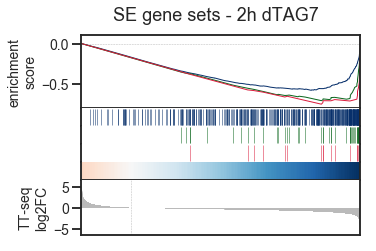

In [105]:
#### make all-in-one GSEA plot

plt.close('all')
sns.set_style('ticks')
sns.set_context('talk')

fig, ax = plt.subplots(7, figsize=(5,4), gridspec_kw={'height_ratios': [4,1,1,1,1,3,1], 'hspace': 0})

# lineplot
ax[0].axhline(0, linestyle='--', linewidth=.5, color='#bababa')
sns.lineplot(ax=ax[0], x=SE_2h_results.gene_rank.append(pd.Series(0)), y=SE_2h_results.running_ES.append(pd.Series(0)), linewidth=1, color='#08306b')
sns.lineplot(ax=ax[0], x=TF_2h_results.gene_rank.append(pd.Series(0)), y=TF_2h_results.running_ES.append(pd.Series(0)), linewidth=1, color='#0a661d')
sns.lineplot(ax=ax[0], x=autoreg_2h_results.gene_rank.append(pd.Series(0)), y=autoreg_2h_results.running_ES.append(pd.Series(0)), linewidth=1, color='#db1d3d')
# vlines
ax[1].vlines(x=SE_2h_results.gene_rank, ymin=0, ymax=1, linewidth=.5, color='#08306b') # this is if you want to color the target gene set in the waterfall plot
ax[2].vlines(x=TF_2h_results.gene_rank, ymin=0, ymax=1, linewidth=.5, color='#0a661d') # this is if you want to color the target gene set in the waterfall plot
ax[3].vlines(x=autoreg_2h_results.gene_rank, ymin=0, ymax=1, linewidth=.5, color='#db1d3d') # this is if you want to color the target gene set in the waterfall plot
# colorbar
img = sns.heatmap(rnk_2h.iloc[:,[1,2]], center=zero_crossing_2h, cmap="RdBu", cbar_ax=ax[4], cbar_kws={'orientation': 'horizontal', 'ticks': []})
img.set_visible(False)
# waterfall
ax[5].axvline(zero_crossing_2h, linestyle='--', linewidth=.5, color='#bababa')
ax[5].vlines(x=rnk_2h.index, ymin=0, ymax=rnk_2h.ranking_score, linewidth=.25, color='#bababa')


# control figure aesthetics
ax[4].set_frame_on(True)

sns.despine(ax=ax[0], top=False, right=False)
sns.despine(ax=ax[1], bottom=True, right=False)
sns.despine(ax=ax[2], bottom=True, right=False)
sns.despine(ax=ax[3], bottom=True, right=False)
sns.despine(ax=ax[4], right=False)
sns.despine(ax=ax[5], right=False)

ax[0].set_xlim(0,len(rnk_2h))
ax[1].set_xlim(0,len(rnk_2h))
ax[2].set_xlim(0,len(rnk_2h))
ax[3].set_xlim(0,len(rnk_2h))
ax[5].set_xlim(0,len(rnk_2h))

ax[0].set_ylim(-0.8,0.1)
ax[5].set_ylim(-6.5,6.5)

ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
ax[3].set_xticks([])
ax[5].set_xticks([])
#ax[3].set_xticks(np.arange(0,len(rnk), 2500))

#ax[0].set_yticks(np.arange(-1.,0.1,0.5))
ax[1].set_yticks([])
ax[2].set_yticks([])
ax[3].set_yticks([])

ax[0].tick_params(labelsize=14)
ax[5].tick_params(labelsize=14)

# add titles
plt.suptitle('SE gene sets - 2h dTAG7', fontsize=18)
ax[0].set_ylabel('enrichment\nscore', fontsize=14)
ax[5].set_ylabel('TT-seq\nlog2FC', fontsize=14)


#plt.savefig(plots_dir + 'GSEA\\MJ-19-30_FigS7G_2h-dTAG_SEgenesets_GSEAplot.pdf', dpi=300)
#plt.savefig(plots_dir + 'GSEA\\MJ-19-30_FigS7G_2h-dTAG_SEgenesets_GSEAplot.png', dpi=300)
plt.show()

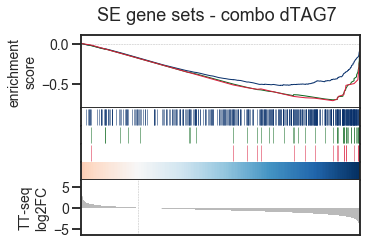

In [106]:
#### make all-in-one GSEA plot

plt.close('all')
sns.set_style('ticks')
sns.set_context('talk')

fig, ax = plt.subplots(7, figsize=(5,4), gridspec_kw={'height_ratios': [4,1,1,1,1,3,1], 'hspace': 0})

# lineplot
ax[0].axhline(0, linestyle='--', linewidth=.5, color='#bababa')
sns.lineplot(ax=ax[0], x=SE_combo_results.gene_rank.append(pd.Series(0)), y=SE_combo_results.running_ES.append(pd.Series(0)), linewidth=1, color='#08306b')
sns.lineplot(ax=ax[0], x=TF_combo_results.gene_rank.append(pd.Series(0)), y=TF_combo_results.running_ES.append(pd.Series(0)), linewidth=1, color='#0a661d')
sns.lineplot(ax=ax[0], x=autoreg_combo_results.gene_rank.append(pd.Series(0)), y=autoreg_combo_results.running_ES.append(pd.Series(0)), linewidth=1, color='#db1d3d')
# vlines
ax[1].vlines(x=SE_combo_results.gene_rank, ymin=0, ymax=1, linewidth=.5, color='#08306b') # this is if you want to color the target gene set in the waterfall plot
ax[2].vlines(x=TF_combo_results.gene_rank, ymin=0, ymax=1, linewidth=.5, color='#0a661d') # this is if you want to color the target gene set in the waterfall plot
ax[3].vlines(x=autoreg_combo_results.gene_rank, ymin=0, ymax=1, linewidth=.5, color='#db1d3d') # this is if you want to color the target gene set in the waterfall plot
# colorbar
img = sns.heatmap(rnk_combo.iloc[:,[1,2]], center=zero_crossing_combo, cmap="RdBu", cbar_ax=ax[4], cbar_kws={'orientation': 'horizontal', 'ticks': []})
img.set_visible(False)
# waterfall
ax[5].axvline(zero_crossing_combo, linestyle='--', linewidth=.5, color='#bababa')
ax[5].vlines(x=rnk_combo.index, ymin=0, ymax=rnk_combo.ranking_score, linewidth=.25, color='#bababa')


# control figure aesthetics
ax[4].set_frame_on(True)

sns.despine(ax=ax[0], top=False, right=False)
sns.despine(ax=ax[1], bottom=True, right=False)
sns.despine(ax=ax[2], bottom=True, right=False)
sns.despine(ax=ax[3], bottom=True, right=False)
sns.despine(ax=ax[4], right=False)
sns.despine(ax=ax[5], right=False)

ax[0].set_xlim(0,len(rnk_combo))
ax[1].set_xlim(0,len(rnk_combo))
ax[2].set_xlim(0,len(rnk_combo))
ax[3].set_xlim(0,len(rnk_combo))
ax[5].set_xlim(0,len(rnk_combo))

ax[0].set_ylim(-0.8,0.1)
ax[5].set_ylim(-6.5,6.5)

ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
ax[3].set_xticks([])
ax[5].set_xticks([])
#ax[3].set_xticks(np.arange(0,len(rnk), 2500))

#ax[0].set_yticks(np.arange(-1.,0.1,0.5))
ax[1].set_yticks([])
ax[2].set_yticks([])
ax[3].set_yticks([])

ax[0].tick_params(labelsize=14)
ax[5].tick_params(labelsize=14)

# add titles
plt.suptitle('SE gene sets - combo dTAG7', fontsize=18)
ax[0].set_ylabel('enrichment\nscore', fontsize=14)
ax[5].set_ylabel('TT-seq\nlog2FC', fontsize=14)


#plt.savefig(plots_dir + 'GSEA\\MJ-19-30_FigS7G_combo-dTAG-NVP2_SEgenesets_GSEAplot.pdf', dpi=300)
#plt.savefig(plots_dir + 'GSEA\\MJ-19-30_FigS7G_combo-dTAG-NVP2_SEgenesets_GSEAplot.png', dpi=300)
plt.show()

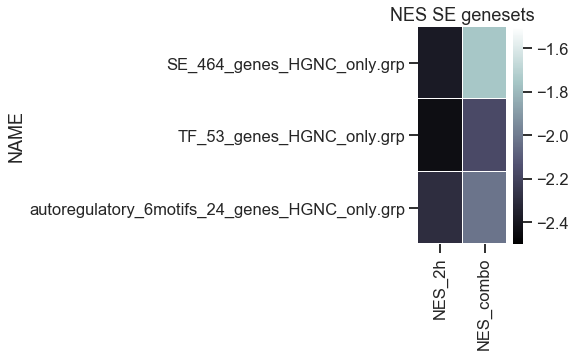

In [160]:
#### make NES heatmap

results_2h = pd.read_csv("S:\\lab_winter\\martin\\MED14_PRO-seq_final\\other_final_files\\MJ-19-30_dTAG7_NVP2_combo\\MJ-19-30_TT-seq_2h_intersection_16631_log2FC_ranked_for_GSEA\\gsea_report_for_na_neg_1572434756307.xls", sep="\t", index_col=0).iloc[:,4]
results_combo = pd.read_csv("S:\\lab_winter\\martin\\MED14_PRO-seq_final\\other_final_files\\MJ-19-30_dTAG7_NVP2_combo\\MJ-19-30_TT-seq_combo_intersection_16631_log2FC_ranked_for_GSEA\\gsea_report_for_na_neg_1572434756319.xls", sep="\t", index_col=0).iloc[:,4]

plot_df = pd.merge(results_2h, results_combo, suffixes=['_2h', '_combo'], on="NAME").reindex(["SE_464_genes_HGNC_only.grp", "TF_53_genes_HGNC_only.grp", "autoregulatory_6motifs_24_genes_HGNC_only.grp"])

# plot
plt.close('all')
sns.set_style('ticks')
sns.set_context('talk')
plt.figure(figsize=(2,4))

sns.heatmap(plot_df, vmin=-2.5, vmax=-1.5, cmap="bone", linewidths=0.25)

plt.title("NES SE genesets")

#plt.savefig(plots_dir + 'GSEA\\MJ-19-30_FigS7G_combo-dTAG-NVP2_SEgenesets_NES_heatmap.pdf', dpi=300)
#plt.savefig(plots_dir + 'GSEA\\MJ-19-30_FigS7G_combo-dTAG-NVP2_SEgenesets_NES_heatmap.png', dpi=300)
plt.show()
